# Modules

In [1]:
from __future__ import print_function, division
import numpy as np
import random
import os
import glob
#import cv2
import datetime
import pandas as pd
import time
import h5py
import csv
import re
from PIL import Image as pil_image
from sklearn.preprocessing import LabelEncoder

from scipy.misc import imresize, imsave
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle

from PIL import Image, ImageChops, ImageOps
import matplotlib.pyplot as plt

import sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gzip
import pickle
from collections import Counter
import keras
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, model_from_json
from keras.layers import Dense, Flatten, Dropout
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import fbeta_score
from tqdm import tqdm_notebook as tqdm
%matplotlib inline


/home/jlevyabi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


#  Set up folder architecture for learning

In [ ]:
%%bash
#mkdir /datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/train/
#mkdir /datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/test/
mkdir /datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/
ori=pwd
prop=80 # 100 files per class 80 % into training set
for f in /datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/Images/*/
do
    cp $f/* /datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/
    #ls |sort -R >  /datastore/complexnet/jlevyabi/ml_soc_econ/inter
    #head -$prop inter| cp /datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/train/
    #tail -n +$prop inter| cp /datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/train/
    #rm inter
done
cd $ori

#  Input Preprocessing

In [2]:
def load_img(path, grayscale=False, target_size=None):
    """Loads an image into PIL format.
    # Arguments
        path: Path to image file
        grayscale: Boolean, whether to load the image as grayscale.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if target_size:
        hw_tuple = (target_size[1], target_size[0])
        if img.size != hw_tuple:
            img = img.resize(hw_tuple)
    return img

def array_to_img(x, data_format=None, scale=True):
    """Converts a 3D Numpy array to a PIL Image instance.
    # Arguments
        x: Input Numpy array.
        data_format: Image data format.
        scale: Whether to rescale image values
            to be within [0, 255].
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if invalid `x` or `data_format` is passed.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    x = np.asarray(x, dtype=K.floatx())
    if x.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape:', x.shape)
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format:', data_format)
    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)
    if data_format == 'channels_first':
        x = x.transpose(1, 2, 0)
    if scale:
        x = x + max(-np.min(x), 0)
        x_max = np.max(x)
        if x_max != 0:
            x /= x_max
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return pil_image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise ValueError('Unsupported channel number: ', x.shape[2])


def img_to_array(img, data_format=None):
    """Converts a PIL Image instance to a Numpy array.
    # Arguments
        img: PIL Image instance.
        data_format: Image data format.
    # Returns
        A 3D Numpy array.
    # Raises
        ValueError: if invalid `img` or `data_format` is passed.
    """
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: ', data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=K.floatx())
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: ', x.shape)
    return x



In [3]:
def list_pictures(directory, ext='jpg|jpeg|bmp|png|tif'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f)]

def database_image(shape=(256,256,3),
                   directory="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/"):
    images=list_pictures(directory)
    X,y,y_name=[],[],[]
    for im in images:
        im_print=load_img(im)
        im_array=img_to_array(im_print)
        if im_array.shape[0]>shape[0]:
            result=im_array[:shape[0],:shape[1],:shape[2]]
        else:
            result = np.zeros(shape)
            result[:im_array.shape[0],:im_array.shape[1],:im_array.shape[2]] = im_array
        X.append(result)
        y.append(im.split("/")[-1][:-6])
        y_name.append(im)
    return X,y,y_name

In [15]:
X,encoded,encoded_name=database_image()
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(encoded)
y = to_categorical(integer_encoded)

dic_int_to_label={}
for lab,nb in zip(encoded,integer_encoded):
    dic_int_to_label.setdefault(nb,lab)


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=4)
_,_,name_train,name_test=train_test_split(X,encoded_name,test_size=0.2, random_state=4)

X_train=np.stack(X_train)
X_test=np.stack(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Model Definition

In [4]:
def fbs(y_true, y_pred, threshold_shift=0., beta=1):
    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred_bin, 0, 1)))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

def f2_score(y_true, y_pred):
    # fbs throws a confusing error if inputs are not numpy arrays
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # We need to use average='samples' here, any other average method will generate bogus results
    return fbs(y_true, y_pred, beta=2, average='samples')

def instantiate(n_classes, n_dense=1024, resnet_json="resnet50_mod.json", target_size=(256,256,3), verbose=1):
    """
    Instantiate the resnet 50.
    """
    # create the base pre-trained model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=target_size)
    # add a global spatial average pooling layer
    x = base_model.output
    x = Flatten()(x)
    # and a final logistic layer
    predictions = Dense(n_classes, activation='sigmoid')(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers[:-5]:
        layer.trainable = False
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=Adam(lr=0.0001), loss="binary_crossentropy", metrics=[fbs])
    # serialize model to json
    model_json = model.to_json()
    with open(resnet_json, "w") as iOF:
        iOF.write(model_json)
    return base_model, model


def finetune(base_model, model, X_train, y_train, X_val, y_val,
             epochs_1=1000, patience_1=2,
             patience_lr=1, batch_size=32,
             nb_train_samples=1600, nb_validation_samples=500,
             img_width=256, img_height=256, class_imbalance=False,
             resnet_h5_1="resnet50_fine_tuned_1.h5",
             resnet_h5_check_point_1="resnet50_fine_tuned_check_point_1.h5",
             layer_names_file="resnet50_mod_layer_names.txt", verbose=1):
    """
    Finetune the resnet 50.
    """
    # let's visualize layer names and layer indices to see how many layers
    # we should freeze:
    with open(layer_names_file, "w") as iOF:
        for ix, layer in enumerate(model.layers):
            iOF.write("%d, %s\n"%(ix, layer.name))
            if verbose >= 4: print(ix, layer.name)
    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
        featurewise_center=True,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rotation_range=180,
        fill_mode='reflect')
    train_datagen.fit(X_train)
    # this is the augmentation configuration we will use for testing:
    test_datagen = ImageDataGenerator(
        featurewise_center=True,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rotation_range=180,
        fill_mode='reflect')
    test_datagen.fit(X_train)
    # define train & val data generators
    train_generator = train_datagen.flow(X_train,y_train,batch_size=batch_size,shuffle=True)
    validation_generator = test_datagen.flow(X_val,y_val,batch_size=batch_size,shuffle=True)
    # get class weights
    if class_imbalance:
        class_weight = get_class_weights(np.sum(y_train, axis=0), smooth_factor=0.1)
    else:
        class_weight = None
    # train the model on the new data for a few epochs on the batches generated by datagen.flow().
    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs_1,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', patience=patience_1),
                   ModelCheckpoint(filepath=resnet_h5_check_point_1, save_best_only=True),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=patience_lr)],
        class_weight=class_weight)
    # save weights just in case
    model.save_weights(resnet_h5_1)


In [7]:
verbose=1
model_dir="/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/"
if verbose >= 1: 
    print("\tInstantiating ResNet50 (fold )...")
n_classes = y_train.shape[1]
base_model, model = instantiate(n_classes, n_dense=1024, resnet_json=model_dir+"resnet50_mod_.json", target_size=(256,256,3), verbose=verbose)


	Instantiating ResNet50 (fold )...


# Training

In [241]:
if verbose >= 1: print("\tFine-tuning ResNet50 first pass (fold )...")
finetune(base_model, model, X_train, y_train, X_test, y_test, batch_size=16, epochs_1=25,
         nb_train_samples=len(y_train), nb_validation_samples=len(y_test),
         img_width=256, img_height=256,
         patience_1=100, patience_lr=100, class_imbalance=False,
         resnet_h5_1=model_dir+"resnet50_fine_tuned_1_.h5",
         resnet_h5_check_point_1=model_dir+"resnet50_fine_tuned_check_point_1_.h5",
         layer_names_file=model_dir+"resnet50_mod_layer_names.txt",
         verbose=verbose)

	Fine-tuning ResNet50 first pass (fold )...
Epoch 1/5
105/105 [==============================] - 197s - loss: 0.0206 - fbs: 0.9209 - val_loss: 0.0222 - val_fbs: 0.9205
Epoch 2/5
105/105 [==============================] - 196s - loss: 0.0188 - fbs: 0.9325 - val_loss: 0.0221 - val_fbs: 0.9217
Epoch 3/5
105/105 [==============================] - 194s - loss: 0.0193 - fbs: 0.9308 - val_loss: 0.0239 - val_fbs: 0.9212
Epoch 4/5
105/105 [==============================] - 195s - loss: 0.0186 - fbs: 0.9342 - val_loss: 0.0230 - val_fbs: 0.9163
Epoch 5/5
105/105 [==============================] - 196s - loss: 0.0184 - fbs: 0.9339 - val_loss: 0.0204 - val_fbs: 0.9210


In [ ]:
resnet_json="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/resnet50_mod_.json"
with open(resnet_json, 'r') as iOF:
    loaded_model_json = iOF.read()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/resnet50_fine_tuned_1_.h5")
if verbose >= 1: print("Loaded model from disk")

# Sampling the quality of prediction in tet set

In [242]:
import os
cwd = os.getcwd()
test_sample_data,_,test_sample_labels,_=train_test_split(X_test, y_test, test_size=0.4, random_state=4)
_,_,sample_name,_=train_test_split(X_test, name_test, test_size=0.4, random_state=4)
sample_of_quality=[]
pres_explained=[]
for x,y,z in tqdm(zip(test_sample_data,test_sample_labels,sample_name)):
    true=dic_int_to_label[(np.argmax(y))]
    alg_says=loaded_model.predict(x.reshape((1,256, 256, 3)))
    pred=dic_int_to_label[(np.argmax(alg_says))]
    pres_explained.append({dic_int_to_label[it]: round(val,3)
                           for it, val in enumerate(alg_says.tolist()[0])})
    sample_of_quality.append((pred,true,z.replace(cwd+"/","")))

sample_of_quality_df=pd.DataFrame(sample_of_quality,columns=["true_lab","pred_lab","image_name"])
sample_of_quality_df["image"]=sample_of_quality_df["image_name"].apply(lambda x: '<img src="{}"/>'.format(x) if x else '')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [248]:
from IPython.display import Image, HTML
pd.set_option('display.max_colwidth', 1000)
HTML(sample_of_quality_df[["true_lab","pred_lab","image"]].sample(6).to_html(escape=False))

In [245]:
sample_of_quality_df.sample(5)

true_lab      pred_lab  \
76       airplane      airplane   
195      overpass      overpass   
201  agricultural  agricultural   
243      overpass       freeway   
116    parkinglot    parkinglot   

                                                                                image_name  \
76       ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/airplane45.tif   
195      ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/overpass24.tif   
201  ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/agricultural24.tif   
243       ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/freeway98.tif   
116    ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/parkinglot45.tif   

                                                                                                  image  
76       <img src="ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/airplane45.tif"/>  
195      <img src="ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/overpass24.tif"/>  
201  <img src="ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/agricultural24.tif"/>  
243       <img src="ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/freeway98.tif"/>  
116    <img src="ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/full/parkinglot45.tif"/>

# Application to Twitter dataset

## Modules

In [3]:
import numpy as np
import pandas as pd
from unicodedata import normalize
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tkr
from collections import Counter
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd
pd.options.display.max_colwidth = 100
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import re
import unidecode

## Load Model trained on UCMerced

In [5]:
verbose=1
resnet_json="/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/resnet50_mod_.json"
with open(resnet_json, 'r') as iOF:
    loaded_model_json = iOF.read()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/UCMerced_LandUse/resnet50_fine_tuned_1_.h5")
if verbose >= 1: print("Loaded model from disk")

Loaded model from disk


## French geolocated tweets

In [9]:
data_14=pd.read_csv("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/2014-2015_locs.txt",sep="\t",
                   header=-1,names=["id","time","lat","lon","text"],
                    dtype={"id":"int","time":"str","lat":"float64","lon":"float64","text":"str"},
                   parse_dates=['time'])
data_18=pd.read_csv("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/2016-2018_locs.txt",sep="\t",
                   header=-1,names=["id","time","lat","lon","text"],
                    dtype={"id":"int","time":"str","lat":"float64","lon":"float64","text":"str"},
                   parse_dates=['time'])
full_data=pd.concat([data_14,data_18])
full_data["geometry"]=[Point(x.lon,x.lat) for it,x in (full_data[["lon","lat"]].iterrows())]
full_data.crs = {'init': 'epsg:4326'}
print("Shape of full_data: ", full_data.shape)
print("Column names of full_data: ", full_data.columns)
full_data["geometry"]=[Point(x.lon,x.lat) for it,x in (full_data[["lon","lat"]].iterrows())]
full_data.crs = {'init': 'epsg:4326'}
france=Polygon([[-4.9658203125,42.3585439175],[8.4375,42.3585439175],
                [8.4375,51.2344073516],[-4.9658203125,51.2344073516],[-4.9658203125,42.3585439175]])
locs=[Point((lon,lat)) for lon,lat in zip(full_data.lon,full_data.lat)]
full_data_france=full_data[[france.contains(geo_pt) for geo_pt in tqdm_notebook(locs)]]
print("Shape of full_data_france: ", full_data_france.shape)
print("Column names of full_data_france: ", full_data_france.columns)
full_data_france.head()

## Tweets mentioning home

In [ ]:
from PIL import Image as imj
def get_thumbnail(path):
    i = imj.open(path)
    i.thumbnail((150, 150), imj.LANCZOS)
    return i

nb_samples,_=suspected_home_loc_df.shape
image_data=[None] * nb_samples
fname="ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_19/"
for file in tqdm_notebook(glob.glob(fname+"*.png")):
    filename=file.replace(fname,"")
    nb,_,idx=filename.split("_")
    image_data[int(nb)]=file

suspected_home_loc_df["file"]=image_data
suspected_home_loc_df['Image'] = suspected_home_loc_df.file.map(lambda f: get_thumbnail(f))
suspected_home_loc_df['new'] = suspected_home_loc_df['file'].apply(lambda x: '<img src="{}"/>'.format(x) if x else '')

In [ ]:
n_classes=21
from tqdm import tqdm 
import json
im_best_pred,im_all_preds=[],[]
for im_real_data in tqdm(suspected_home_loc_df_ld.file):
    img_real = pil_image.open(im_real_data)
    img_real=img_real.convert(mode="RGB")
    pix = np.array(img_real)
    alg_says=loaded_model.predict(img_to_array(img_real).reshape((1,256, 256, 3)))
    pres_explained={dic_int_to_label[it]: round(val,3) for it, val in enumerate(alg_says.tolist()[0])}
    im_best_pred.append(dic_int_to_label[(np.argmax(alg_says))])
    im_all_preds.append(json.dumps({k:v for k,v in pres_explained.items() if v>2.0/n_classes}))

suspected_home_loc_df_ld["best_pred"]=im_best_pred
suspected_home_loc_df_ld["all_pred"]=im_all_preds

In [152]:
from IPython.display import Image, HTML
pd.set_option('display.max_colwidth', 1000)
HTML(suspected_home_loc_df_ld[["time","lat","lon","new","all_pred"]].sample(6).to_html(escape=False))

In [92]:
Point(1,2).intersects(Point(1,2))

True

In [ ]:
suspected_home_loc_df_ld.head()

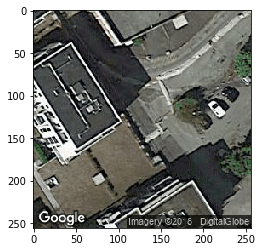

In [59]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

im_real_data=suspected_home_loc_df_ld.sample(1).file.values[0]
img_real = pil_image.open(im_real_data)
img_real=img_real.convert(mode="RGB")
pix = np.array(img_real)
preds=loaded_model.predict(img_to_array(img_real).reshape((1,256, 256, 3)))
#pres_explained={dic_int_to_label[it]: round(val,3) for it, val in enumerate(alg_says.tolist()[0])}
#pred=dic_int_to_label[(np.argmax(alg_says))]
#print({k:v for k,v in pres_explained.items() if v>1.0/n_classes})

plt.imshow(img_real)

In [6]:
file="ml_soc_econ/data_files/images_suspected_locs/suspects_street/0_imag_127925773_ang_0.png"
import base64
with open(file, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
img_tag = ('<img src="data:image/png;base64,{0}">'.format(encoded_string.decode("utf-8")))


(600, 640, 3)


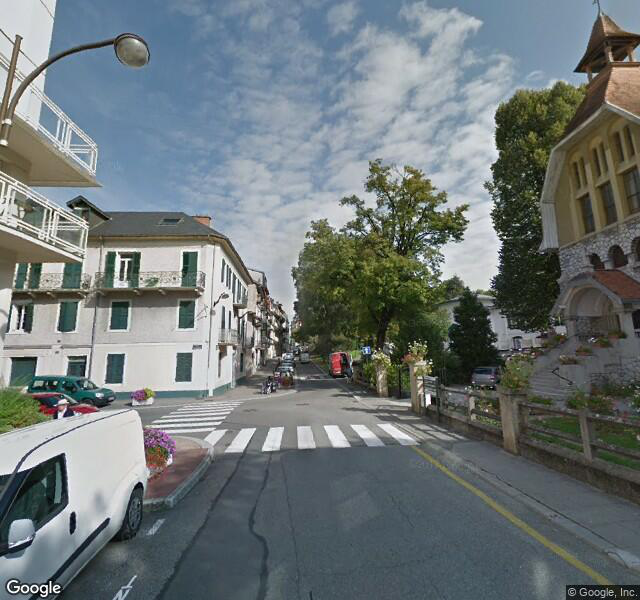

In [115]:
im_real_data="ml_soc_econ/data_files/images_suspected_locs/suspects_street/0_imag_127925773_ang_0.png"
img_real = pil_image.open(im_real_data)
img_real=img_real.convert(mode="RGB")
pix = np.array(img_real)
print(pix.shape)
#alg_says=loaded_model.predict(img_to_array(img_real).reshape((1,256, 256, 3)))
#pres_explained={dic_int_to_label[it]: round(val,3)
#                           for it, val in enumerate(alg_says.tolist()[0])}
#pred=dic_int_to_label[(np.argmax(alg_says))]
#print({k:v for k,v in pres_explained.items() if v>2.0/n_classes})
img_real

In [12]:
dic_is_residence={'sparseresidential':1,
                  'intersection':0,
                  'storagetanks':0,
                  'beach':0,
                  'overpass':0,
                  'buildings':1,
                  'airplane':0,
                  'agricultural':0,
                  'golfcourse':0,
                  'parkinglot':0,
                  'freeway':0,
                'mediumresidential':1,
                  'denseresidential':1,
                  'runway':0,
                'river':0,
                  'mobilehomepark':1,
                'baseballdiamond':0,
                  'chaparral':0, 
                  'tenniscourt':0,
                  'harbor':0,
                  'forest':0}

suspected_home_loc_df["ishome"]=[ sum([dic_is_residence[key] for key in json.loads(preds).keys()]) 
                                 for best,other in suspected_home_loc_df[["best_pred","all_pred"]] ]

In [ ]:
suspected_home_loc_df.to_pickle("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/suspected_home_loc_df.p")

## Checkpoint: Load  dataset with predictions

In [7]:
import pandas as pd
suspected_home_loc_df_ld=pd.read_pickle(
    "/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/suspected_home_loc_df.p")

In [3]:
afik_suspected_home_fr=suspected_home_loc_df_ld[suspected_home_loc_df_ld.ishome]

In [5]:
import pickle
dic_final_not_nan=pickle.load(open(
    "/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/all_together_dic.p","rb"))

In [6]:
print ("Number of geolocated users in filters+mode .... %d"%len(set(dic_final_not_nan.keys())))
print ("Number of geolocated users in home_words+gmaps .... %d"%len(set(afik_suspected_home_fr.id)))
print ("Number of geolocated users in both .... %d"%
       len(set(dic_final_not_nan.keys()).intersection(set(afik_suspected_home_fr.id.astype(str)))))

Number of geolocated users in filters+mode .... 28397
Number of geolocated users in home_words+gmaps .... 22101
Number of geolocated users in both .... 8590


In [7]:
from geopandas import GeoDataFrame
dic_gmaps={}
for it,row in afik_suspected_home_fr.iterrows():
    dic_gmaps.setdefault(str(row.id),[])
    dic_gmaps[str(row.id)].append(row)

dic_gmaps={k:GeoDataFrame(v)for k,v in dic_gmaps.items()}

In [10]:
from collections import Counter
import numpy as np
dic_most_freq_gmaps={k: Counter([(x[0],x[1])
                                 for x in (dic_gmaps[k][["lat","lon"]].astype(np.double).round(3).values)]).most_common(1)[0][0]
                     for k in dic_gmaps.keys()}
dic_most_freq_filters={k: Counter([(x[0],x[1])
                                   for x in (dic_final_not_nan[k][["lat","lon"]].astype(np.double).round(3).values)]).most_common(1)[0][0]
                     for k in dic_final_not_nan.keys()}

In [11]:
keys_gmaps = set(dic_most_freq_gmaps.keys())
keys_filters = set(dic_most_freq_filters.keys())
keys_both = keys_gmaps & keys_filters # '&' operator is used for set intersection

In [12]:
df_both=pd.DataFrame([(k,dic_most_freq_filters[k],dic_most_freq_gmaps[k]) for k in keys_both],
                     columns=["id","filter","maps"])

In [13]:
both_same=np.array([x==y for x,y in df_both[["filter","maps"]].values])
both_diff=~np.array([x==y for x,y in df_both[["filter","maps"]].values])

In [30]:
import pickle
pickle.dump(list(df_both[both_same].id),open("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/locs_same_home_voc.p","wb"))


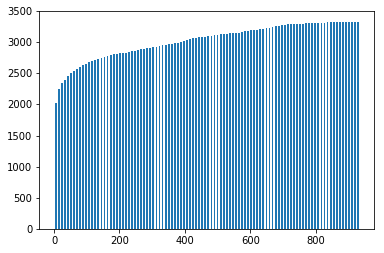

In [25]:
import matplotlib.pyplot as plt
from geopy.distance import vincenty
plt.hist(distance_maps_filter,log=False,bins=100,rwidth=0.6,cumulative=True)
plt.show()

## Enrich HTML with Street View + Other Zooms of GMaps

In [11]:
import geopandas as gpd
import numpy as np
iris_fname = "/datastore/complexnet/jlevyabi/geoloc/iris_opendata/shapefile_iris/contours-iris-2016.geojson"
df_iris = gpd.read_file(iris_fname)
df_iris.crs = {'init': 'epsg:4326'}
df_iris=df_iris[[not(x is None) for x in df_iris.geometry]]

In [12]:
from geopandas import GeoDataFrame
from shapely.geometry import  Point, Polygon, MultiPolygon
suspected_home_loc_df_ld["geometry"]=[Point(y,x) for x,y in suspected_home_loc_df_ld[["lat","lon"]].values]
suspected_home_loc_df_geo=GeoDataFrame(suspected_home_loc_df_ld)
suspected_home_loc_df_geo.crs = {'init': 'epsg:4326'}

In [14]:
from tqdm import tqdm_notebook as tqdm
import os.path
import base64
tohtml_zm17=[]
tohtml_zm18=[]
tohtml_zm19=[]
tohtml_street_coords=[]
tohtml_street=[]
df_street=pd.read_csv("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/street_info.csv",
                     usecols=[1,2,3,4])
j=0

for it,fname in tqdm(enumerate(suspected_home_loc_df_ld.file)):
    dir2="ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_17/"
    dir0="ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_18/"
    dir1="ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_19/"
    dir_street="/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/suspects_street/"
    imag=fname.split("/")[-1]
    try:
        with open(dir2+imag, "rb") as image_file:
            encoded_string_zm17 = base64.b64encode(image_file.read())
            img_tag_zm17 = ('<img src="data:image/png;base64,{0}">'.format(encoded_string_zm17.decode("utf-8")))
    except:
        img_tag_zm17=None
    with open(dir0+imag, "rb") as image_file:
        encoded_string_zm18 = base64.b64encode(image_file.read())
    with open(dir1+imag, "rb") as image_file:
        encoded_string_zm19 = base64.b64encode(image_file.read())
    street=[]
    for ang in [-120,-60,0,60,120,180]:
        rw=df_street.iloc[j]
        tohtml_street_coords.append((rw.lat,rw.lon))
        f_street=dir_street+imag.replace(".png","")+"_ang_"+str(ang)+".png"
        if rw.status=="OK" and os.path.isfile(f_street):
            with open(f_street, "rb") as image_file:
                street_imag=base64.b64encode(image_file.read())
                street_tag = ('<img height="256" width="256" src="data:image/png;base64,{0}">'.format(street_imag.decode("utf-8")))
                street.append(street_tag)
        elif rw.status=="ZERO_RESULTS":
            street.append(None)
        else:
            street.append(None)
        j+=1       
    img_tag_zm18 = ('<img src="data:image/png;base64,{0}">'.format(encoded_string_zm18.decode("utf-8")))
    img_tag_zm19 = ('<img src="data:image/png;base64,{0}">'.format(encoded_string_zm19.decode("utf-8")))
    tohtml_zm17.append(img_tag_zm17)
    tohtml_zm18.append(img_tag_zm18)
    tohtml_zm19.append(img_tag_zm19)
    tohtml_street.append(street)

suspected_home_loc_df_ld["tohtml_zm17"]=tohtml_zm17
suspected_home_loc_df_ld["tohtml_zm18"]=tohtml_zm18
suspected_home_loc_df_ld["tohtml_zm19"]=tohtml_zm19
ang_list=["tohtml_street_ang_%s"%str(ang) for ang in [-120,-60,0,60,120,180]]
for it,ang in enumerate(ang_list):
    suspected_home_loc_df_ld[ang]=[pic[it] for pic in tohtml_street]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [79]:
from IPython.display import Image, HTML
pd.set_option('display.max_colwidth', 1000)
HTML(suspected_home_loc_df_geo[["time","lat","lon","new","ishome"]].sample(1).to_html(escape=False))

In [58]:
html = """<HTML>
<body>
    <h1><font size="20">Sample of locations</h1>
    <font size="3" face="Courier New" >
    <table  cellspacing="20">
      <tr>
        <th>Index</th>
        <th>Latitude</th>
        <th>Longitude</th>
        <th>Zoom 1</th>
        <th>Zoom 2</th>
        <th>Zoom 3</th>
        <th>-120&#186;</th>
        <th>POV -60&#186;</th>
        <th>POV 0&#186;</th>
        <th>POV 60&#186;</th>
        <th>POV 120&#186;</th>
        <th>POV 180&#186;</th>
      </tr>
        {0}
    </table>
</body>
</HTML>"""

tr = "<tr>{0}</tr>"
td = "<td>{0}</td>"
y=[]
j=0
for it,item in suspected_home_loc_df_ld[["lat","lon","tohtml_zm17","tohtml_zm18","tohtml_zm19"]+ang_list].sample(10000,random_state=1).iterrows():
    if item.values[-1] and not (None in item.values) and item.values[-2]!=item.values[-3]:
        x=[td.format(j),]
        item["lat"]=np.round(item["lat"],5)
        item["lon"]=np.round(item["lon"],5)
        for a in item.values:
            x.append(td.format(a))
        j+=1
        y.append(tr.format(" ".join(x)))

In [59]:
sample=(html.format(" ".join(y[:100]))) 
html_file= open("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/sample.html","w")
html_file.write(sample)
html_file.close()

In [67]:
import pandas as pd 

ans=pd.DataFrame([(i,"","") for i in range(100)],columns=["Index","Answer","Confidence"])
writer = pd.ExcelWriter('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/sample_answer.xlsx',)
ans.to_excel(writer,'Sheet1', index=False,)
writer.save()


In [43]:
from math import floor
from tqdm import tqdm_notebook
dic_usr_to_home={}
my_floor= lambda x: floor(x*1000.0)/1000.0

for k, row in tqdm_notebook(suspected_home_loc_df_ld.iterrows()):
    usr,time,lat,lon,text,ishome=row[["id","time","lat","lon","text","ishome"]]
    if ishome:
        dic_usr_to_home.setdefault(usr,[])
        dic_usr_to_home[usr].append((time,(lat),(lon),text))
for k,v in dic_usr_to_home.items():
    dic_usr_to_home[k]=pd.DataFrame(v,columns=["time","lat","lon","text"])

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [65]:
import pickle
pickle.dump(dic_usr_to_home,
            open("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/dic_home_suspect_residential.p","wb"))

## Architecture Real Sample

In [66]:
suspected_home_loc_df_geo_city=gpd.sjoin(suspected_home_loc_df_geo[suspected_home_loc_df_geo.ishome], df_iris, how="inner", op='within')

In [67]:
from geopandas import GeoDataFrame
dic_gmaps_city={}
for it,row in suspected_home_loc_df_geo_city.iterrows():
    if str(row.id) in df_both[both_same].id.values:
        dic_gmaps_city.setdefault(str(row.id),[])
        dic_gmaps_city[str(row.id)].append(row)

dic_gmaps_city={k:GeoDataFrame(v) for k,v in dic_gmaps_city.items()}

In [68]:
full_archi_sample=[]
for k,v in dic_gmaps_city.items():
    locs=[(x[0],x[1]) for x in v[["lat","lon"]].astype(np.double).round(3).values]
    most_common_locs=Counter(locs).most_common(1)[0][0]
    indx=locs.index(most_common_locs)
    full_archi_sample.append(v.values[indx])

full_archi_sample_df=pd.DataFrame(full_archi_sample,columns=v.columns)

In [69]:
full_archi_sample_df.head(2)

id                time        lat       lon  \
0  127925773 2014-06-19 15:45:21  45.685930  5.914163   
1  330982164 2015-01-21 14:54:46  48.991093  2.250402   

                                                                                                                        text  \
0  Et d'un autre côté je trouve ça dommage d'empêcher les élèves de s'habiller comme ils veulent , ça fait leur personnalité   
1                                                                         @Velycureuil omg j'crois qu'on a le même telephone   

     weekday  hour  \
0   Thursday    15   
1  Wednesday    14   

                                                                                       file  \
0      ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_19/0_imag_127925773.png   
1  ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_19/53860_imag_330982164.png   

                                                                           Image  \
0  <PIL.PngImagePlugin.PngImageFile image mode=P size=150x150 at 0x7F38A8A88748>   
1  <PIL.PngImagePlugin.PngImageFile image mode=P size=150x150 at 0x7F38A58A94A8>   

                                                                                                     new  \
0      <img src="ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_19/0_imag_127925773.png"/>   
1  <img src="ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_19/53860_imag_330982164.png"/>   

     ...      iris          nom_iris  typ_iris     nom_region insee_com  \
0    ...      0102  Centre Ville-Sud         H    RHONE-ALPES     73008   
1    ...      0501    Les Esperances         H  ILE-DE-FRANCE     95219   

       p12_pop        nom_com code_dept    nom_dept  code_iris  
0  2748.014046  Aix-les-Bains        73      SAVOIE  730080102  
1  2881.467719         Ermont        95  VAL-D'OISE  952190501  

[2 rows x 34 columns]

In [80]:
from IPython.display import Image, HTML
pd.set_option('display.max_colwidth', 1000)
HTML(full_archi_sample_df[["time","lat","lon","new","ishome"]].sample(1).to_html(escape=False))

In [58]:
html = """<HTML>
<body>
    <h1><font size="20">Sample of locations</h1>
    <font size="3" face="Courier New" >
    <table  cellspacing="20">
      <tr>
        <th>Index</th>
        <th>Latitude</th>
        <th>Longitude</th>
        <th>Longitude</th>
        <th>Zoom 1</th>
        <th>Zoom 2</th>
        <th>Zoom 3</th>
        <th>-120&#186;</th>
        <th>POV -60&#186;</th>
        <th>POV 0&#186;</th>
        <th>POV 60&#186;</th>
        <th>POV 120&#186;</th>
        <th>POV 180&#186;</th>
      </tr>
        {0}
    </table>
</body>
</HTML>"""

tr = "<tr>{0}</tr>"
td = "<td>{0}</td>"
y=[]
j=0
for it,item in full_archi_sample_df[["lat","lon","tohtml_zm17","tohtml_zm18","tohtml_zm19"]+ang_list].sample(10000,random_state=1).iterrows():
    if item.values[-1] and not (None in item.values) and item.values[-2]!=item.values[-3]:
        x=[td.format(j),]
        item["lat"]=np.round(item["lat"],5)
        item["lon"]=np.round(item["lon"],5)
        for a in item.values:
            x.append(td.format(a))
        j+=1
        y.append(tr.format(" ".join(x)))

## Home Location to SES

Run [this](#Cython_Helpers) appendix first 

In [106]:
suspected_home_loc_df_ld["geometry"]=[Point((lon,lat)) for lat, lon in suspected_home_loc_df_ld[["lat","lon"]].values]
loc2insee=my_pt2poly(GeoDataFrame(suspected_home_loc_df_ld),
                     geo_insee_dic,set(geo_insee_dic_KEYS))

nb_vars=geo_insee.shape[1]
all_together=[]
for index in tqdm_notebook(loc2insee):
    if not(index is None):
        insee_value=geo_insee.iloc[index]
        all_together.append(insee_value.values.tolist())
    else:
        all_together.append([None for i in range(nb_vars)])

insee=pd.DataFrame(all_together)
insee.columns=geo_insee.columns

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=104392), HTML(value='')))

In [117]:
insee["insee_id"]=insee.id
del insee["id"]
df_final=pd.concat([suspected_home_loc_df_ld,insee],
                   ignore_index=True,axis=1)
df_final.columns=list(suspected_home_loc_df_ld.columns)+list(insee.columns)
df_final["income"]=df_final["ind_srf"]/df_final["ind_r"]
df_final["owner_ratio"]=df_final["men_prop"]/df_final["ind_r"]
df_final["density"]=df_final["ind_r"]/(0.04*df_final["nbcar_x"])
df_final.drop(["income.1","Unnamed: 0","nbcar_x"],axis=1,inplace=True)
df_final_not_nan=df_final[[not(x is None) for x in df_final.idINSPIRE]]
df_final_not_nan.head(2)

id                time        lat       lon  \
0   127925773 2014-06-19 15:45:21  45.685930  5.914163   
2  2477134008 2014-06-19 15:50:21  48.910233  2.307839   

                                                                                                                        text  \
0  Et d'un autre côté je trouve ça dommage d'empêcher les élèves de s'habiller comme ils veulent , ça fait leur personnalité   
2                                                           Tous les tonton sont poser au maquis pour regarder le match #Civ   

    weekday  hour  \
0  Thursday    15   
2  Thursday    15   

                                                                                    file  \
0   ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_19/0_imag_127925773.png   
2  ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_19/2_imag_2477134008.png   

                                                                           Image  \
0  <PIL.PngImagePlugin.PngImageFile image mode=P size=150x150 at 0x7F692D706F60>   
2  <PIL.PngImagePlugin.PngImageFile image mode=P size=150x150 at 0x7F692B33A128>   

                                                                                                  new  \
0   <img src="ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_19/0_imag_127925773.png"/>   
2  <img src="ml_soc_econ/data_files/images_suspected_locs/suspects_png_zm_19/2_imag_2477134008.png"/>   

    ...    i_age7 ind_age8  i_age8     ind_srf nbcar_y  \
0   ...       0.0     29.0     0.0   4112092.0     1.0   
2   ...       0.0     30.0     0.0  30347202.0     1.0   

                                                                                                                                                                                           geometry  \
0   POLYGON ((5.91360057124234 45.68514833482669, 5.916161399860631 45.68524714746363, 5.916026886417699 45.68704605625028, 5.913465974416134 45.686947240512, 5.91360057124234 45.68514833482669))   
2  POLYGON ((2.30607188738108 48.90866788860899, 2.308787362407975 48.90885549843577, 2.30850851291302 48.91064322377021, 2.305793081536957 48.91045560790529, 2.30607188738108 48.90866788860899))   

         income               insee_id  owner_ratio  density  
0  19769.673077  LAEA200M_N12584E20012     0.298077   5200.0  
2  18221.075953  LAEA200M_N14478E18790     0.087061  41637.5  

[2 rows x 46 columns]

## Images ICDM_18

### UCMerced Dataset

In [ ]:
from tqdm import tqdm_notebook
types={k:0 for k in list(set(encoded))}
for mix,miy in tqdm_notebook(zip(X,encoded)):
    types[miy]=mix

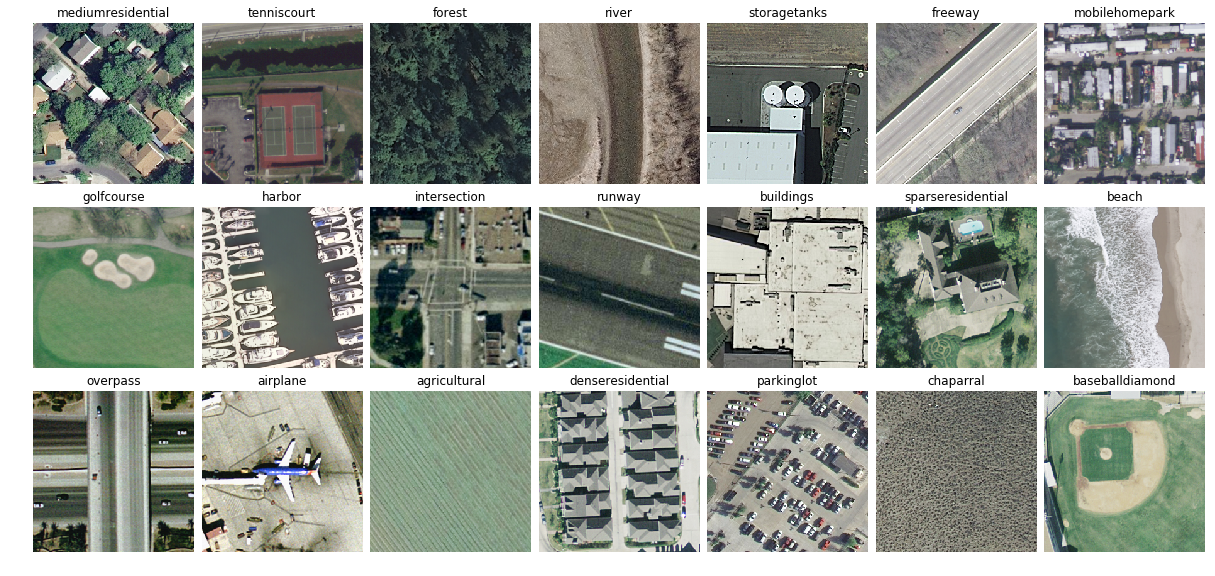

In [172]:
plt.figure(figsize=(21,10))
for it,k in enumerate(types.keys()):
    plt.subplot(3,7,it+1)
    plt.imshow(np.array(types[k],dtype=np.uint8))
    plt.axis("off")
    plt.title(k,fontsize=16)
plt.subplots_adjust(wspace=0.05, hspace=0.05,)
plt.savefig('/datastore/complexnet/jlevyabi/ml_soc_econ/icdm18/ucmerced.pdf', bbox_inches='tight')
plt.show()

### Activations in neural network

In [9]:
import keras.backend as K


def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print("")
            #print(layer_activations.shape)
        else:
            print("")
            #print(layer_activations)
    return activations


def display_activations(activation_maps,im):
    import numpy as np
    import matplotlib.pyplot as plt
    """
    (1, 26, 26, 32)
    (1, 24, 24, 64)
    (1, 12, 12, 64)
    (1, 12, 12, 64)
    (1, 9216)
    (1, 128)
    (1, 128)
    (1, 10)
    """
    plt.figure(figsize=(40,40))
    plt.subplot(1,4,1)
    plt.imshow(im)
    plt.axis('off')
    batch_size = activation_maps[0].shape[0]
    x=[]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate([activation_maps[i] for i in [0,3,7]]):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        print(shape)
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.subplot(1,4,i+2)
        x.append(np.mean(activation_map[0],axis=2))
        plt.imshow(np.mean(activation_map[0],axis=2), interpolation='None', cmap='jet',)    
        plt.axis('off')
    plt.savefig("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/icdm18/resnet_gmaps_activ1.pdf")
    plt.show()
    return x

----- activations -----
















































































































































































Displaying activation map 0
(1, 256, 256, 3)
Displaying activation map 1
(1, 128, 128, 64)
Displaying activation map 2
(1, 63, 63, 64)


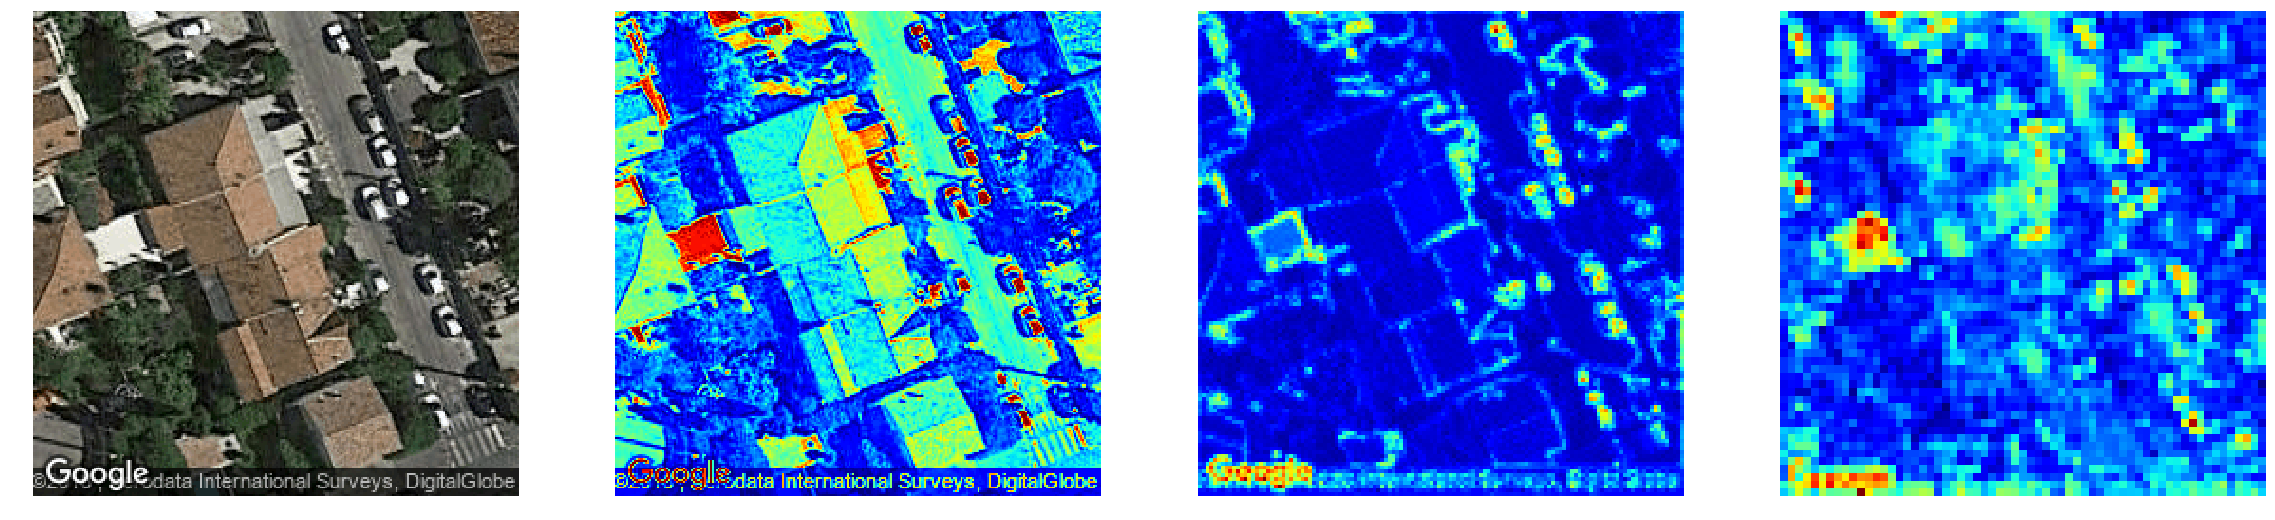

In [19]:
actics=get_activations(loaded_model, np.array(test_im).reshape((-1,256, 256, 3)), print_shape_only=True, layer_name=None)
a=display_activations(actics,test_im)


### Predictions

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as grd

def make_predition(model, img_np):
    """Make predictions for an image.  
    
    Parameters
    ----------
    model : Keras.models.Model
        Your model.
    img_np : numpy.ndarray (len(shape)=4)
        Array of images as numpy arrays.
        
    Returns
    -------
    List
    """
    img_real = pil_image.open(im_real_data)
    img_real=img_real.convert(mode="RGB")
    pix = np.array(img_real)
    inter=loaded_model.predict(img_to_array(img_real).reshape((1,256, 256, 3)))
    alg_says=np.array(inter)/np.sum(inter)
    pres_explained={dic_int_to_label[it]: round(val,5) for it, val in enumerate(alg_says.tolist()[0])}
    return img_real,pres_explained

def plot_preds(image, preds,topn,act=a):
    fig = plt.figure(figsize=(20,10))
    # create a 2 X 2 grid 
    #gs = gridspec.GridSpec(3, 3)
    gs = grd.GridSpec(2, 3, width_ratios=[1.7,1,1], wspace=0.2)
    
    # image plot
    ax = plt.subplot(gs[:,0])
    ax.imshow(image,interpolation='nearest',aspect='equal')

    keys=list(preds.keys())
    vals=list(preds.values())
    preds={keys[i]:preds[keys[i]] for i in sorted(range(len(vals)), key=lambda i: vals[i], reverse=True)[:topn]}
    
    ax.axis('off')
    order = list(reversed(range(len(preds.keys()))))  
    bar_preds = list(preds.values())
    labels = list(preds.keys())
    
    ax11=plt.subplot(gs[0,1])
    plt.imshow(a[0], interpolation='None', cmap='jet',)    
    plt.axis('off')
    ax12=plt.subplot(gs[0,2])
    plt.imshow(a[1], interpolation='None', cmap='jet',)    
    plt.axis('off')
    
    ft_size=20
    ax2=plt.subplot(gs[1,1:])
    ax2.barh(order, bar_preds, alpha=0.99,edgecolor="black",linewidth=4)
    plt.yticks(order, labels,fontsize=ft_size,rotation=30)
    plt.xticks(fontsize=ft_size,)
    plt.xlabel('Probability',fontsize=ft_size)
    plt.xlim(0, 1.01)
    plt.savefig("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/icdm18/resnet_gmaps1.pdf")
    plt.show()



In [24]:
import pickle
dic_fig_3={
    "test_im":test_im,
    "test_pred":test_pred,
    "activation":a
}
pickle.dump(dic_fig_3,open("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/icdm18/issues/rep_figure/fig3.p","wb"))

list

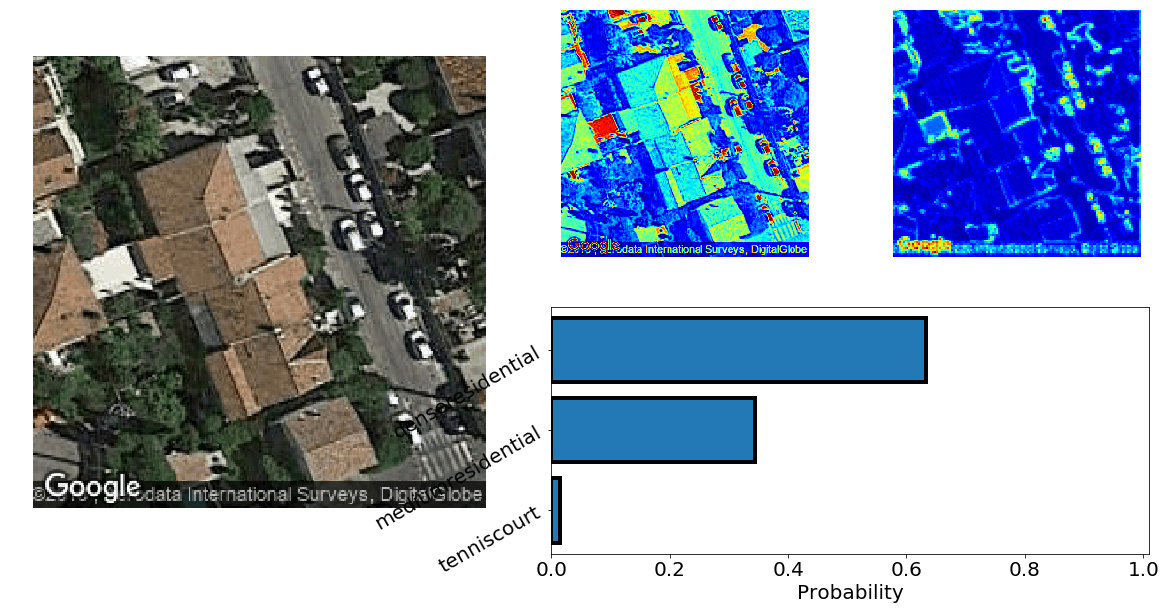

In [22]:
im_real_data=suspected_home_loc_df_ld.sample(1,random_state=42).file.values[0]
test_im,test_pred=make_predition(loaded_model,im_real_data)
plot_preds(test_im,test_pred,topn=3)

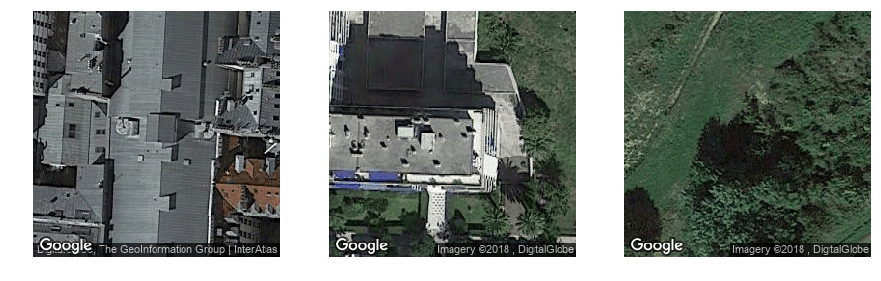

In [136]:
plt.figure(figsize=(15,15))
nb=3
for i in range(nb):
    plt.subplot(1,nb,i+1)
    b=suspected_home_loc_df_ld.sample(1,random_state=(1+i)*13).file.values[0]
    a = pil_image.open(b)
    hola=a.convert(mode="RGB")
    hola = np.array(hola)
    plt.imshow(hola)
    plt.axis("off")
plt.savefig("/datastore/complexnet/jlevyabi/ml_soc_econ/icdm18/gmaps_sample.pdf")
plt.show()

In [3]:
import pandas as pd

# Appendix 

## INSEE Enrichments

In [189]:
x=[8,9,10,11,12,13,15,20,25,30,40,50,60,70,80,100,150,200,500]
y=[60850,84163,118472,127544,147071,172326,514180,1791159,2662049,3839342,7507935,4785218,2413332,
   922038,428521,456517,325267,24556,1996]

In [207]:
%%bash
pwd

/datastore/complexnet/jlevyabi


bash: /home/jlevyabi/seacabo/geoanaconda/anaconda3/lib/libtinfo.so.5: no version information available (required by bash)


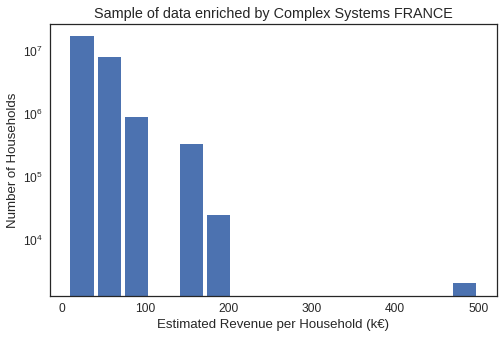

In [208]:
sns.plt.figure(figsize=(8,5))
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)  # crazy big
sns.set_style("white")
plt.hist(x, weights=y,rwidth=0.85,bins=15,log=True)
plt.xlabel("Estimated Revenue per Household (k€)")
plt.ylabel("Number of Households")
plt.title ("Sample of data enriched by Complex Systems FRANCE")
plt.savefig("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/complex_systems.pdf")

In [124]:
print("Average salary per household is %.2f k€"%np.average(x,weights=y))

Average salary per household is 42.33 k€


Mmmm muy similar a los datos que nos han proporcionado

## Cython_Helpers

In [92]:
%load_ext cython

In [93]:
%%cython -l geos_c -L/home/jlevyabi/seacabo/geoanaconda/anaconda3/lib -I/home/jlevyabi/seacabo/geoanaconda/anaconda3/include -a

import cython
cimport cpython.array

import numpy as np
cimport numpy as np

cdef extern from "geos_c.h":
    ctypedef void *GEOSContextHandle_t
    ctypedef struct GEOSGeometry
    char GEOSContains_r(GEOSContextHandle_t, const GEOSGeometry*, const GEOSGeometry*) nogil
    
cdef GEOSContextHandle_t get_geos_context_handle():
    # Note: This requires that lgeos is defined, so needs to be imported as:
    from shapely.geos import lgeos
    cdef np.uintp_t handle = lgeos.geos_handle
    return <GEOSContextHandle_t>handle


@cython.boundscheck(False)
@cython.wraparound(False)
def contains_cy_insee(np.int64_t[:] array_usrs, np.int64_t[:]array_insee ):
    
    cdef Py_ssize_t idx
    cdef unsigned int n = array_usrs.size
    cdef unsigned int n_geo = array_insee.size
    cdef np.ndarray[np.uint8_t, ndim=2, cast=True] result = np.empty([n,n_geo],dtype=np.uint8)

    cdef GEOSContextHandle_t geos_handle
    cdef GEOSGeometry *geom1
    cdef GEOSGeometry *geom2
    cdef np.uintp_t geos_geom_usrs
    cdef np.uintp_t geos_geom_insee

    geos_h = get_geos_context_handle()
    for idx in xrange(n):
        for idx_geos in xrange(n_geo):
            geos_geom_usrs = array_usrs[idx]
            geom2 = <GEOSGeometry *>geos_geom_usrs
            geos_geom_insee = array_insee[idx_geos]
            geom1 = <GEOSGeometry *> geos_geom_insee
            
            # Put the result of whether the point is "contained" by the
            # prepared geometry into the result array. 
            result[idx][idx_geos] = <np.uint8_t> GEOSContains_r(geos_h, geom1, geom2)
            #GEOSGeom_destroy_r(geos_h, geom2)

    return result.view(dtype=np.bool)

In [94]:
def my_pt2poly(usr_df,country_dic,set_keys):
    usr_info=[];prec=2;step=10**(-prec);vals=[-step,0,step]
    test=[]
    map_prec = lambda x: str(round(x,prec))
    for it,usr in tqdm_notebook(usr_df.iterrows()):
        us_posx,us_posy=usr.geometry.centroid.bounds[:2]  
        usr_geom=usr.geometry._geom
        keys=(set([(map_prec(us_posy+yval),map_prec(us_posx+xval))
              for xval in vals for yval in vals])).intersection(set_keys)
        pre_df_of_concern=[country_dic[key]
                       for key in keys if country_dic[key].shape[0]>0]
        df_of_concern=[y._geom 
                       for x in pre_df_of_concern for y in x.geometry]
        df_ilocs_concern=[y
                       for x in pre_df_of_concern for y in x["Unnamed: 0"]]
        if len(df_of_concern)==0:
            test.append(None)
            continue
        #insee_to_check = pd.concat(df_of_concern)
        geom_to_check = df_of_concern#np.array([x._geom for x in (insee_to_check.geometry)])
        assignments=(contains_cy_insee(np.array([usr_geom]), np.array(geom_to_check)))
        to_check=np.where(assignments)
        _,poly=to_check
        if len(poly)==0:
            test.append(None)
        else:
            test.append(df_ilocs_concern[poly[0]])
    return test

In [96]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd

pat = re.compile(r'''(-*\d+\.\d+ -*\d+\.\d+);*''')
new_geo=[]
df_insee=pd.read_csv('/datastore/complexnet/jlevyabi/geoloc/final_exact.csv',sep=";")
#Cast data into shapely format
for geo in tqdm_notebook(df_insee.geometry):
    matches = pat.findall(geo)
    if matches:
        lst = Polygon([tuple(map(float, m.split())) for m in matches])
    else:
        lst=None
    new_geo.append(lst)

presentable_insee_df=df_insee
presentable_insee_df=presentable_insee_df.convert_objects(convert_numeric=True)
presentable_insee_df['geometry']=new_geo
geo_insee = GeoDataFrame(presentable_insee_df)
geo_insee.crs={'init': 'epsg:4326'}

lat,lon=[],[]
for poly in tqdm_notebook(geo_insee.geometry ):
    for coor_pair in poly.exterior.coords[:]:
        lat.append(coor_pair[1])
        lon.append(coor_pair[0])
min_lat,max_lat=np.min(lat),np.max(lat)
min_lon,max_lon=np.min(lon),np.max(lon)
del lon;del lat

prec=2
map_prec = lambda x: str(round(x,prec))
step=10**(-prec)
lat_grid = np.arange(start=min_lat, stop=max_lat+step,step= step)
lon_grid = np.arange(start=min_lon,stop=max_lon+step,step=step)

geo_insee_dic_KEYS=[]
for my_lat in tqdm_notebook(lat_grid):
    for my_lon in lon_grid:
        lat2str,lon2str=map_prec(my_lat),map_prec(my_lon)
        geo_insee_dic_KEYS.append((lat2str,lon2str))

geo_insee_dic={key:[] for key in geo_insee_dic_KEYS}
for it,poly in tqdm_notebook(geo_insee.iterrows()):
    center_x,center_y=poly.geometry.centroid.bounds[:2]
    cx,cy=map_prec(center_x),map_prec(center_y)
    if cx=="-0.0":
        cx="0.0"
    geo_insee_dic[(cy,cx)].append(poly)

# Divide original GeoDF into small geodfs for each patch of territory
for k,v in tqdm_notebook(geo_insee_dic.items()):
    df_coord=GeoDataFrame(v);df_coord.crs={'init': 'epsg:4326'}
    geo_insee_dic[k]=df_coord

HBox(children=(IntProgress(value=0, max=2278213), HTML(value='')))

/home/jlevyabi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


HBox(children=(IntProgress(value=0, max=2278213), HTML(value='')))

HBox(children=(IntProgress(value=0, max=973), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

2141029it [16:28, 2166.03it/s]


HBox(children=(IntProgress(value=0, max=1430310), HTML(value='')))

1143445/|/ 80%|| 1143445/1430310 [57:48<14:30, 329.69it/s]
